# Testing - PennyLane Implementaion of *QGraphs*

*This notebook explores creation and use of* ***QGgraphs (Quantum Digraphs)*** *in* ***Networkx+PennyLane+PyTorch**.*

**By:** Jacob Cybulski<br>
**Date:** August 2024<br>
**Aims:** The goal of this notebook is to test some *Quantum Digraph (QGraphs)* features and functions.

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [2]:
### General libraries

import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
import pylab
import math
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

## Networkx digraph manipulation

### Digraph drawing

In [3]:
### Draw a digraph
def draw_digraph(G, ax=None, weight_prec=3, font_size=12):
    pos = nx.shell_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.planar_layout(G)
    # pos = nx.spring_layout(G)
    # cstyle = "arc3,rad=0.3"
    cstyle = "arc3"
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=font_size, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color="grey", ax=ax, connectionstyle=cstyle)

In [4]:
### Draw a weighted digraph
def draw_weighted_digraph(G, attr_name, ax=None, weight_prec=3, font_size=12):
    pos = nx.shell_layout(G)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.planar_layout(G)
    # pos = nx.spring_layout(G)
    # cstyle = "arc3,rad=0.3"
    cstyle = "arc3"
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=font_size, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color="grey", ax=ax, connectionstyle=cstyle)

    labels = {tuple(edge) : f"{np.round(attrs[attr_name], weight_prec)}" for *edge, attrs in G.edges(data=True)}
    
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        label_pos=0.35,
        font_color="blue",
        bbox={"alpha": 0},
        verticalalignment='baseline', # top, bottom, center, center_baseline
        ax=ax,
    )

### Digraph generation

In [5]:
from pylab import *
import json
import networkx as nx
from networkx.readwrite import json_graph

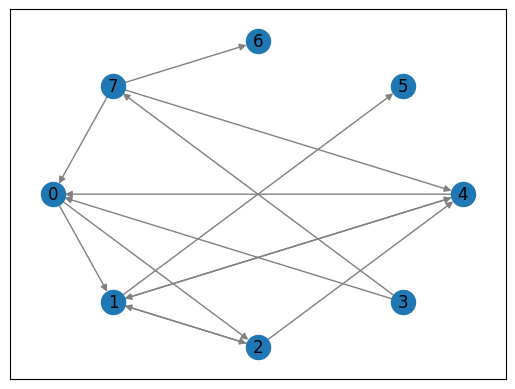

In [6]:
### Create a random graph
node_no = 8
edge_p = 0.25
g = nx.gnp_random_graph(node_no, edge_p, directed=True)
draw_digraph(g)

### Digraph saving and loading

In [7]:
import os

In [8]:
### Saving of a graph to a file
def save_digraph(G, fpath, vers=0):
    os.makedirs(os.path.dirname(fpath), exist_ok=True)
    g_node_links = nx.node_link_data(G)
    with open(f'{fpath}', 'w') as f:
        json.dump(g_node_links, f)
        f.close()

vers = 0
g_path = f'sample_graphs/digraph_{node_no}_{edge_p}_v{vers}.json'
save_digraph(g, g_path)
print(f'Saved graph in file: {g_path}')

Saved graph in file: sample_graphs/digraph_8_0.25_v0.json


Loaded graph from file: sample_graphs/digraph_8_0.25_v2.json


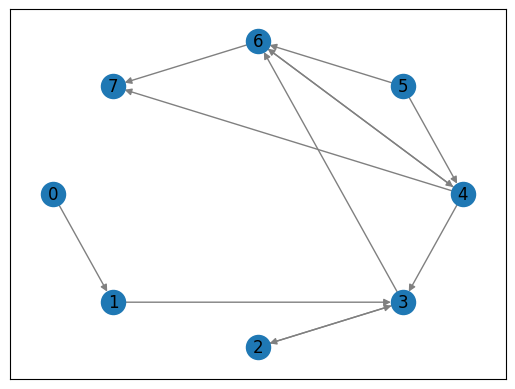

In [9]:
### Loading a graph from a file
def load_digraph(fpath):
    if not os.path.exists(fpath):
        print(f'*** ERROR: The digraph file does not exist or is corrupted: {fpath}')
        return nx.null_graph()
    else:
        try:
            f = open(fpath, 'r')
        except OSError:
            print(f'*** ERROR: Could not open/read the digraph file: {fpath}')
            return nx.null_graph()
        with f:
            with open(f'{fpath}', 'r') as f:
                G_node_links = json.load(f)
                f.close()
            G = nx.node_link_graph(G_node_links)
            return G

g_path = 'sample_graphs/digraph_8_0.25_v2.json'
g_sel = load_digraph(g_path)
draw_digraph(g_sel)
print(f'Loaded graph from file: {g_path}')

In [10]:
nx.node_link_data(g_sel)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7}],
 'links': [{'source': 0, 'target': 1},
  {'source': 1, 'target': 3},
  {'source': 2, 'target': 3},
  {'source': 3, 'target': 2},
  {'source': 3, 'target': 6},
  {'source': 4, 'target': 3},
  {'source': 4, 'target': 6},
  {'source': 4, 'target': 7},
  {'source': 5, 'target': 4},
  {'source': 5, 'target': 6},
  {'source': 6, 'target': 4},
  {'source': 6, 'target': 7}]}

### Generate a QGraph for modeling

***Creation of a quantum digraph includes three stages:***<br/>
- *Converting an undirected graph to an adjacency matrix*
- *Changing all undirected edges to weighted directed edges*
- *Expanding a digraph to a QGraph (quantum digraph) by adding an auxilliary vertex to eliminate stop vertices*

Note that in graph expansion to a quantum graph the additional vertex is added,<br/>
so that on measurement probability of navigation to all destinations adds to 1.<br/><br/>
Also note that changing probabilities of navigation from that auxilliary vertext<br/>
would allow random navigation from stop vertices to some other vertex.

In [11]:
### Convert an adjacency of a unweighted graph to adjacency of a weighted graph
def digraph_to_weighted_adj(unw_adj):
    w_adj = np.zeros((unw_adj.shape[0], unw_adj.shape[1]))
    for r in range(unw_adj.shape[0]):
        r_sum = sum(unw_adj[r])
        if r_sum != 0.0:
            # Edges available - generate random weights
            nz_weights = np.random.random(r_sum)
            nz_weights /= nz_weights.sum()
            w_no = 0
            for c in range(unw_adj.shape[1]):
                if unw_adj[r, c] > 0:
                    w_adj[r, c] = nz_weights[w_no]
                    w_no += 1
    return w_adj

### Expand a weighted digraph to eliminate vertices with out-dgree=0
def digraph_weighted_adj_expand(w_adj):
    exp_adj = np.zeros((w_adj.shape[0]+1, w_adj.shape[1]+1))
    exp_adj[:-1, :-1] = w_adj
    for r in range(w_adj.shape[0]):
        r_sum = np.count_nonzero(w_adj[r])
        if r_sum == 0:
            # No outgoing links - redirect to dummy
            exp_adj[r, -1] = 1.0
    exp_adj[-1, -1] = 1.0
    return exp_adj

### Prepare a quantum digraph for quantum modeling
#   Convert an undirected graph into QGraph
def digraph_weight_and_expand(g):
    g_adj = nx.adjacency_matrix(g)
    g_weighted_adj = digraph_to_weighted_adj(g_adj)
    g_expanded_adj = digraph_weighted_adj_expand(g_weighted_adj)
    g_new = nx.DiGraph(g_expanded_adj)
    return g_new

### Testing generation of QGraphs

In [12]:
### We are going to use the previously loaded digraph g_sel
g_sel_node_no = g_sel.number_of_nodes()
g_sel_edge_no = g_sel.number_of_edges()
print(f'Digraph of {g_sel_node_no} nodes and {g_sel_edge_no} edges')

Digraph of 8 nodes and 12 edges


#### First let us do this step by step and observe results

In [13]:
### Convert a graph to an adjacency matrix
import scipy as sci # Not used as yet
adj_sel = nx.adjacency_matrix(g_sel)
adj_sel.toarray()

/tmp/ipykernel_237992/2114991748.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_sel = nx.adjacency_matrix(g_sel)


array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
### Generate edge probability weights (adding to 1.0)
w_adj_new = digraph_to_weighted_adj(adj_sel)
np.around(w_adj_new, 3)

array([[0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.582, 0.   , 0.   , 0.   , 0.418, 0.   ],
       [0.   , 0.   , 0.   , 0.254, 0.   , 0.   , 0.144, 0.602],
       [0.   , 0.   , 0.   , 0.   , 0.536, 0.   , 0.464, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.499, 0.   , 0.   , 0.501],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

In [15]:
### Expand the weighted digraph to eliminate stop vertices (out-degree=0)
w_exp_adj = digraph_weighted_adj_expand(w_adj_new)
np.around(w_exp_adj, 3)

array([[0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.582, 0.   , 0.   , 0.   , 0.418, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.254, 0.   , 0.   , 0.144, 0.602, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.536, 0.   , 0.464, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.499, 0.   , 0.   , 0.501, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

#### Now let us generate a QGraph in a single step

/tmp/ipykernel_237992/770260367.py:32: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  g_adj = nx.adjacency_matrix(g)


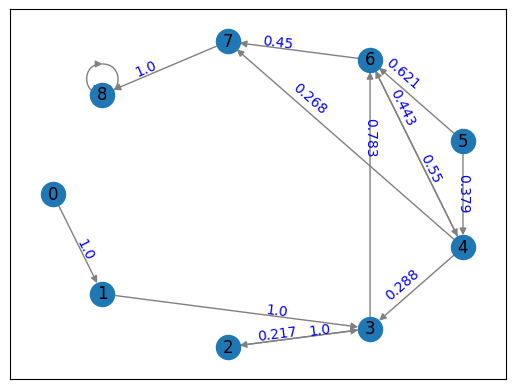

In [16]:
### Test graph generation in one step
g_new = digraph_weight_and_expand(g_sel)
# nx.draw(g_new, with_labels = True)
draw_weighted_digraph(g_new, 'weight', ax=None)

In [17]:
nx.node_link_data(g_new)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7},
  {'id': 8}],
 'links': [{'weight': 1.0, 'source': 0, 'target': 1},
  {'weight': 1.0, 'source': 1, 'target': 3},
  {'weight': 1.0, 'source': 2, 'target': 3},
  {'weight': 0.21699676526703748, 'source': 3, 'target': 2},
  {'weight': 0.7830032347329625, 'source': 3, 'target': 6},
  {'weight': 0.2881967942056622, 'source': 4, 'target': 3},
  {'weight': 0.4434279392770846, 'source': 4, 'target': 6},
  {'weight': 0.26837526651725324, 'source': 4, 'target': 7},
  {'weight': 0.37941473329578007, 'source': 5, 'target': 4},
  {'weight': 0.6205852667042199, 'source': 5, 'target': 6},
  {'weight': 0.5503142902357854, 'source': 6, 'target': 4},
  {'weight': 0.4496857097642146, 'source': 6, 'target': 7},
  {'weight': 1.0, 'source': 7, 'target': 8},
  {'weight': 1.0, 'source': 8, 'target': 8}]}

## PennyLane Implementation
*To be added next*

In [18]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
import torch
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [19]:
def draw_circuit(circuit, fontsize=20, style='pennylane', expansion_strategy=None, scale=None, title=None, decimals=2):
    def _draw_circuit(*args, **kwargs):
        nonlocal circuit, fontsize, style, expansion_strategy, scale, title
        qml.drawer.use_style(style)
        if expansion_strategy is None:
            expansion_strategy = circuit.expansion_strategy
        fig, ax = qml.draw_mpl(circuit, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
        if scale is not None:
            dpi = fig.get_dpi()
            fig.set_dpi(dpi*scale)
        if title is not None:
            fig.suptitle(title, fontsize=fontsize)
        plt.show()
    return _draw_circuit

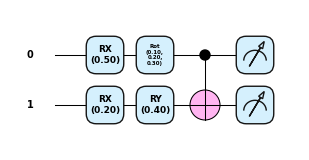

In [20]:
##### Just testing an arbitrary circuit creation

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights_0, weight_1):
    qml.RX(inputs[0], wires=0)
    qml.RX(inputs[1], wires=1)
    qml.Rot(*weights_0, wires=0)
    qml.RY(weight_1, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.Z(0)), qml.expval(qml.Z(1))

draw_circuit(qnode, scale=0.5)([0.5, 0.2], [0.1, 0.2, 0.3], 0.4)

## System

In [21]:
!pip list | grep -e torch -e PennyLane -e networkx

networkx                  2.8.8
PennyLane                 0.36.0
PennyLane_Lightning       0.36.0
PennyLane_Lightning_GPU   0.36.0
PennyLane-Rigetti         0.36.0
torch                     2.3.1+cu121
torchaudio                2.3.1+cu121
torchsummary              1.5.1
torchvision               0.18.1+cu121
